In [477]:
import numpy as np
import matplotlib.pyplot as plt
# from numba import jit, cuda
from mpl_toolkits.mplot3d import Axes3D

In [478]:
def temp_log(reason, *args):
    nolog = list()
    nolog.append("full_image")
    nolog.append("gett")
    nolog.append("rltest")
    nolog.append("trace1")
    if reason in nolog:
        return
    print(*args)

In [479]:
def normalize(vector):
    return vector / np.linalg.norm(vector)

class PlaneEquation:
    def __init__(self, a=None,b=None,c=None,d=None):
        self.a = a
        self.b = b
        self.c = c
        self.d = d

class Face:
    def __init__(self, v1, v2, v3, v4):
        # A face of 4 vertices
        self.vertices = np.array([v1,v2,v3,v4])
        self.normal = None
        self.equation = PlaneEquation()
        self.color = np.array([255,255,255])

    def __repr__(self):
        # return f"face {self.vertices}, color {self.color}"
        return f"face, color {self.color}"

    def check_coplaner(self):
        c1 = np.cross(self.vertices[0] - self.vertices[1], self.vertices[1] - self.vertices[2])
        c2 = np.cross(self.vertices[1] - self.vertices[2], self.vertices[2] - self.vertices[3])
        c3 = np.cross(self.vertices[2] - self.vertices[3], self.vertices[3] - self.vertices[0])
        c4 = np.cross(self.vertices[3] - self.vertices[0], self.vertices[1] - self.vertices[2])

        cc1 = np.cross(c1,c2)
        cc2 = np.cross(c1,c3)
        cc3 = np.cross(c1,c4)

        if np.linalg.norm(cc1)!=0 :
            raise ValueError(f"Face points not coplanar, vertices = {self.vertices}. Failed for c1, c2. c1={c1} c2={c2}  ")

        if np.linalg.norm(cc2)!=0 :
            raise ValueError(f"Face points not coplanar, vertices = {self.vertices}. Failed for c1, c3. c1={c1} c3={c3}  ")

        if np.linalg.norm(cc3)!=0 :
            raise ValueError(f"Face points not coplanar, vertices = {self.vertices}. Failed for c1, c4. c1={c1} c4={c4}  ")

    def build_normal(self):
        cross = np.cross(self.vertices[1] - self.vertices[0], self.vertices[2] - self.vertices[0])
        self.normal = normalize(cross)

        D = -1*np.dot(self.normal, self.vertices[0])
        self.equation.d  = D

    def set_color(self, color):
        self.color = color
    # def build_equation(self):
    #     vec1 = self.vertices[2] - self.vertices[0]
    #     vec2 = self.vertices[1] - self.vertices[0]
    #
    #     cp = np.cross(vec1, vec2)
    #
    #     a,b,c = cp
    #     d = -1* np.dot(cp,self.vertices[2])
    #
    #     self.equation = np.array([a,b,c,d])

    def process(self):
        self.check_coplaner()
        self.build_normal()
        # self.build_equation()

class SceneObject:
    def __init__(self, name=""):
        self.name = name
        self.vertices = list()
        self.faces = list()

        self.is_finished = False

        self.color_params = {}

    def add_vertex(self, x, y, z):
        self.vertices.append(np.array([x,y,z]))

    def add_face(self, v1,v2,v3,v4):
        # v1,v2,v3,v4 are the index of vertices. Not actual vector
        face = Face(self.vertices[v1], self.vertices[v2], self.vertices[v3], self.vertices[v4])
        face.process()
        self.faces.append(face)


class CameraScreenImage:
    def __init__(self,s0, s1, s2, s3, dd=10):
        self.dd = dd # distance of camera to screen center
        self.screen_vertices = np.array([s0,s1,s2,s3])
        self.screen_normal_dir = normalize(np.cross(s1 - s0,s3 - s0))
        def vavg(ix):
            return (s0[ix] + s1[ix] + s2[ix] + s3[ix])/float(4)
        self.screen_center = np.array([vavg(0), vavg(1), vavg(2)])
        self.camera = self.screen_center + self.screen_normal_dir*dd
        self.height = int(np.floor(np.linalg.norm(s1-s0)))
        self.width = int(np.floor(np.linalg.norm(s2-s1)))

        self.screen_normal = normalize(np.cross(self.screen_vertices[1] - self.screen_vertices[0], self.screen_vertices[2] - self.screen_vertices[0]))


        self.image = np.zeros((self.height, self.width, 3))

        temp_log("camera","[CAMERA-SCREEN]:", f"Camera at {self.camera}. Screen Center at {self.screen_center}. Height {self.height}  Width {self.width}" )
    # def print_image_values(self):
    #     for i in self.image:
    #         for j in self.image[i]:
    #             print(i,j,self.image[i][j])

In [480]:


# print(image)

In [481]:
def get_all_faces(objects):
    faces = []
    for o in objects:
        faces.extend(o.faces)

    return faces


def get_intersection_t_if_ray_intersects_face(origin, ray_direction, face:Face):
    temp_log("gett", f"[GET T INIT]: Origin: {origin}, Face: {face}, Normal: {face.normal}, D: {face.equation.d}")
    fnorm_R_dot = np.dot(ray_direction, face.normal)
    temp_log("gett", f"[GET T]: normal.ray_dir {fnorm_R_dot}")
    # if dot is 0, plane and ray parallel
    # print("fnorm_dir_dot", fnorm_R_dot)
    if fnorm_R_dot == 0:
        return False,None # parallel ray

    if fnorm_R_dot > 0:
        return False,None # back side face

    numerator = np.dot(face.normal, origin) + face.equation.d
    temp_log("gett", f"[GET T]: numerator: dot(N, O) + D = {numerator}")
    # print("numerator", numerator)
    t = numerator / (-1*fnorm_R_dot)
    temp_log("gett", f"[GET T]: Final T {t}")

    return True, t

def right_left_test_for_face(face:Face, point):


    c = np.cross(face.vertices[1] - face.vertices[0], point - face.vertices[0])
    d1 = np.dot(face.normal, c) > 0

    if d1:
        c = np.cross(face.vertices[2] - face.vertices[1], point - face.vertices[1])
        d2 = np.dot(face.normal, c) > 0

        if d2:
            c = np.cross(face.vertices[3] - face.vertices[2], point - face.vertices[2])
            d3 = np.dot(face.normal, c) > 0

            if d3:
                c = np.cross(face.vertices[0] - face.vertices[3], point - face.vertices[3])
                d4 = np.dot(face.normal, c) > 0

                if d4:
                    temp_log("rltest", f"[RL TEST]: Passed")
                    return True


    return False

height_enum = lambda camscreen: enumerate(np.linspace(camscreen.screen_vertices[1][1],camscreen.screen_vertices[0][1],camscreen.height))
width_enum = lambda camscreen: enumerate(np.linspace(camscreen.screen_vertices[1][0], camscreen.screen_vertices[2][0], camscreen.width))


def trace_for_1_pixel(camscreen:CameraScreenImage,all_faces,row,col, y=None, x=None):
    if y is None:
        y = list(height_enum(camscreen))[row][1]
        temp_log("trace1",f"[TRACE {row} {col} ]: generated y {y}")
    if x is None:
        x = list(width_enum(camscreen))[col][1]
        temp_log("trace1",f"[TRACE {row} {col} ]: generated x {x}")

    temp_log("trace1",f"[TRACE {row} {col} ]: Tracing for x,y {x} {y}")
    cur_pos = np.array([x,y,0])
    ray_dir = normalize(cur_pos - camscreen.camera)
    # ray_dir = -1*camscreen.screen_normal
    temp_log("trace1",f"[TRACE {row} {col} ]: Ray Direction: {ray_dir}")

    face_t_list = list()
    for face in all_faces:
        t_exists,T = get_intersection_t_if_ray_intersects_face(cur_pos, ray_dir, face)
        if t_exists:
            if T > 0:
            # if T > camscreen.dd:
                point = cur_pos + T*ray_dir
                temp_log("trace1",f"[TRACE {row} {col} ]: Point {point} at T {T}")
                if right_left_test_for_face(face, point):
                    temp_log("trace1",f"[TRACE {row} {col} ]: Point {point} inside bounds")
                    # print("ray dir: ", ray_dir, "vertices",face.vertices,"fnorm:", face.normal, "point:",point)
                    face_t_list.append([face,T])
    if face_t_list:
        face_t_list.sort(key=lambda pair: pair[1])
        temp_log("trace1",f"[TRACE {row} {col} :] Match {face_t_list} -- Chosen {face_t_list[0]}")
        camscreen.image[row,col] = np.clip(face_t_list[0][0].color,0,1)

    temp_log("trace1","\n")
def build_for_each_screen_pixel(camscreen:CameraScreenImage, all_faces):
    for i, y in height_enum(camscreen):
        for j, x in width_enum(camscreen):
            # print("\n",i,j, end=" -- ")
            trace_for_1_pixel(camscreen,all_faces,row=i,col=j,y=y,x=x)



In [482]:
def build_object_1():
    obj1 = SceneObject("cube1")
    obj1scale = 3
    offset = 0
    obj1.add_vertex(0,0,0)
    obj1.add_vertex(0,50,0)
    obj1.add_vertex(50,40,0)
    obj1.add_vertex(40,0,0)

    obj1.add_vertex(0+offset,0+offset,1)
    obj1.add_vertex(0+offset,50 +offset,1)
    obj1.add_vertex(50 + offset,40 + offset,1)
    obj1.add_vertex(40 + offset,0 + offset,1)

    # obj1.add_vertex(1,1,10)
    # obj1.add_vertex(1,6,10)
    # obj1.add_vertex(6,6,10)
    # obj1.add_vertex(6,1,10)


    obj1.add_face(0,1,2,3)
    obj1.add_face(4,5,1,0)
    obj1.add_face(7,6,5,4)
    obj1.add_face(3,2,6,7)
    obj1.add_face(3,7,4,0)
    obj1.add_face(1,5,6,2)

    obj1.faces[0].set_color(np.array([0,0,255]))
    obj1.faces[1].set_color(np.array([255,0,0]))
    obj1.faces[2].set_color(np.array([0,255,0]))
    obj1.faces[3].set_color(np.array([255,255,0]))
    obj1.faces[4].set_color(np.array([255,0,255]))
    obj1.faces[5].set_color(np.array([255,255,255]))


    print("obj 1 normal", obj1.faces[0].normal)
    print("obj 1 face 0 D", obj1.faces[0].equation.d)

    return obj1

def build_object_2():
    obj = SceneObject("cuboid2")
    obj1scale = 1
    xoffset = -10
    yoffset = 5
    height = 20
    width = 150
    depth = 20
    xi = -75
    yi = -55
    obj.add_vertex(xi,yi,0)
    obj.add_vertex(xi,yi+height,0)
    obj.add_vertex(xi+width,yi+height,0)
    obj.add_vertex(xi+width,yi,0)

    xiback = -75 -50
    yiback = -55
    width +=100
    obj.add_vertex(xiback,yiback,5)
    obj.add_vertex(xiback,yiback+height,5)
    obj.add_vertex(xiback+width,yiback+height,5)
    obj.add_vertex(xiback+width,yiback,5)

    # obj1.add_vertex(1,1,10)
    # obj1.add_vertex(1,6,10)
    # obj1.add_vertex(6,6,10)
    # obj1.add_vertex(6,1,10)


    obj.add_face(0,1,2,3)
    obj.add_face(4,5,1,0)
    obj.add_face(7,6,5,4)
    obj.add_face(3,2,6,7)
    obj.add_face(3,7,4,0)
    obj.add_face(1,5,6,2)

    obj.faces[0].set_color(np.array([0,0,255]))
    obj.faces[1].set_color(np.array([255,0,0]))
    obj.faces[2].set_color(np.array([0,255,0]))
    obj.faces[3].set_color(np.array([255,255,0]))
    obj.faces[4].set_color(np.array([255,0,255]))
    obj.faces[5].set_color(np.array([255,255,255]))


    print("obj 2 normal", obj.faces[0].normal)
    print("obj 2 face 0 D", obj.faces[0].equation.d)

    return obj

def build_object_3():
    obj = SceneObject("cuboid2")
    obj1scale = 1
    xoffset = 0
    yoffset = 0
    obj.add_vertex(-30,10,5)
    obj.add_vertex(-30,30,5)
    obj.add_vertex(-25,30,5)
    obj.add_vertex(-25,10,5)

    obj.add_vertex(-30+xoffset,10+yoffset,10)
    obj.add_vertex(-30+xoffset,30 +yoffset,10)
    obj.add_vertex(-25 + xoffset,30 +yoffset,10)
    obj.add_vertex(-25 + xoffset,10 +yoffset,10)

    # obj1.add_vertex(1,1,10)
    # obj1.add_vertex(1,6,10)
    # obj1.add_vertex(6,6,10)
    # obj1.add_vertex(6,1,10)


    obj.add_face(0,1,2,3)
    obj.add_face(4,5,1,0)
    obj.add_face(7,6,5,4)
    obj.add_face(3,2,6,7)
    obj.add_face(3,7,4,0)
    obj.add_face(1,5,6,2)

    obj.faces[0].set_color(np.array([0,0,255]))
    obj.faces[1].set_color(np.array([255,0,0]))
    obj.faces[2].set_color(np.array([0,255,0]))
    obj.faces[3].set_color(np.array([255,255,0]))
    obj.faces[4].set_color(np.array([255,0,255]))
    obj.faces[5].set_color(np.array([255,255,255]))


    print("obj 2 normal", obj.faces[0].normal)
    print("obj 2 face 0 D", obj.faces[0].equation.d)

    return obj

def driver():
    # cam_screen = CameraScreenImage(
    #     s0=np.array([-15,-10,0]),
    #     s1 = np.array([-15,10,0]),
    #     s2 = np.array([15,10,0]),
    #     s3 = np.array([15,-10,0])
    # )

    xright = int(40*1)
    ydown = int(30*1)
    cam_screen = CameraScreenImage(
        s0=np.array([-1*xright,-1*ydown,0]),
        s1 = np.array([-1*xright,ydown,0]),
        s2 = np.array([xright,ydown,0]),
        s3 = np.array([xright,-1*ydown,0]),
        dd=1
    )

    temp_log("full_image","image before",cam_screen.image)



    # compute ray 1
    # chk = right_left_test_for_face(obj1.faces[0], np.array([0,-1,4.9]))
    # print("right, left test:", chk)

    obj1 = build_object_1()
    obj2 = build_object_2()
    obj3 = build_object_3()
    all_faces = get_all_faces([obj1,obj2])

    # trace_for_1_pixel(cam_screen,all_faces,29,40)
    build_for_each_screen_pixel(cam_screen,all_faces)
    # temp_log("full_image",cam_screen.image)

    plt.imsave('image.png', cam_screen.image)
    plt.imshow(cam_screen.image)
    return cam_screen

[CAMERA-SCREEN]: Camera at [ 0.  0. -1.]. Screen Center at [0. 0. 0.]. Height 60  Width 80
obj 1 normal [ 0.  0. -1.]
obj 1 face 0 D -0.0
obj 2 normal [ 0.  0. -1.]
obj 2 face 0 D -0.0
obj 2 normal [ 0.  0. -1.]
obj 2 face 0 D 5.0


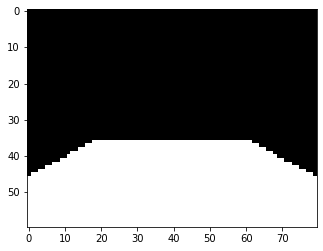

In [483]:

cs = driver()

In [484]:
# print(cs.image[19])

In [485]:
# test plot
def test_plot_3d():
    x, y, z = np.indices((20, 20, 20))

    # draw cuboids in the top left and bottom right corners, and a link between them
    # cube1 = (x < 3) & (y < 3) & (z < 3)
    shape1 = (x >= 10) & (x < 15) & (y >= 10) & (y <= 15) & (z >= 10) & (z < 15)
    # link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

    # combine the objects into a single boolean array
    voxels = shape1 #cube1 | cube2 | link

    # set the colors of each object
    colors = np.empty(voxels.shape, dtype=object)
    # colors[link] = 'red'
    # colors[cube1] = 'blue'
    colors[shape1] = 'green'

    # and plot everything
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(voxels, facecolors=colors, edgecolor='k')

    plt.show()
